In [1]:
!sudo apt-get install -y xvfb ffmpeg
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 13 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 784 kB in 2s (370 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected pack

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.reinforce import reinforce_agent

from tf_agents.drivers import dynamic_step_driver

from tf_agents.environments import suite_gym

from tf_agents.environments import tf_py_environment

from tf_agents.eval import metric_utils

from tf_agents.metrics import tf_metrics

from tf_agents.networks import actor_distribution_network

from tf_agents.replay_buffers import tf_uniform_replay_buffer

from tf_agents.trajectories import trajectory

from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()

# set up virtual display
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()





In [3]:
env_name = "CartPole-v0" # @param {type:"string"}
num_iterations = 250 # @param {type:"integer"}
collect_episodes_per_iteration = 2 # @param {type:"integer"}
replay_buffer_capasity = 2000 # @param {type:"integer"}

fc_layer_params = (100,)

learning_rate = 1e-3 # @param {type:"number"}
log_interval = 25 # @param {type:"integer"}
num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 50 # @param {type:"integer"}

In [4]:
env = suite_gym.load(env_name)
print("Load the artpole enviroment successfully!")

Load the artpole enviroment successfully!


In [5]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [6]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

print("Created the enviroment successfully!")

Created the enviroment successfully!


In [7]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [8]:
optimizer = tf.compat.v1.train.AdadeltaOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns = True,
    train_step_counter=train_step_counter)
tf_agent.initialize()

In [9]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy
print("Created policies successfully!")

Created policies successfully!


In [10]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_eval_episodes
  return avg_return.numpy()[0]

In [11]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capasity)

In [12]:
def collect_episode(environment, policy, num_episodes):

  episode_counter = 0
  environment.reset()

  while episode_counter < num_eval_episodes:
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    replay_buffer.add_batch(traj)

    if traj.is_boundary():
      episode_counter += 1

In [13]:
try:
  %%time
except:
  pass

tf_agent.train = common.function(tf_agent.train)

tf_agent.train_step_counter.assign(0)

avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  collect_episode(
      train_env, tf_agent.collect_policy, collect_episodes_per_iteration)
  
  experience = replay_buffer.gather_all()
  train_loss = tf_agent.train(experience)
  replay_buffer.clear()

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.
step = 25: loss = -0.21636953949928284
step = 50: loss = -0.34083348512649536
step = 50: Average Return = 13.100000381469727
step = 75: loss = -0.4476584494113922
step = 100: loss = -0.2289871722459793
step = 100: Average Return = 19.899999618530273
step = 125: loss = -0.3507756292819977
step = 150: loss = -0.7226411700248718
step = 150: Average Return = 12.600000381469727
step = 175: loss = -0.23479703068733215
step = 200: loss = -0.27667808532714844
step = 200: Average Return = 18.899999618530273
step = 225: loss = -0.6272783875465393
step = 250: loss = -0.4762727618217468
step = 250: Average Return = 24.399999618530273


(12.010000419616699, 250.0)

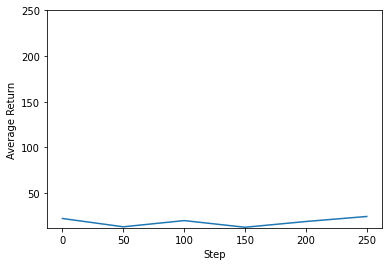

In [14]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=250)

In [15]:
def embed_mp4(filename):
  video = open(filename, 'rb').read()
  b64 = base64.b64encode(video)
  tag='''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [18]:
num_episodes = 3
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = tf_agent.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())

embed_mp4(video_filename)